# Flux Microscopy Image Enhancement Demo

This notebook uses the Flux Kontext model to intelligently enhance cellular microscopy images, improving image clarity and contrast.

In [1]:
# Import necessary libraries
import torch
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import os
import re
import random
import glob

# Load Flux Kontext model
print("Loading Flux Kontext model...")
pipe = FluxKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16
)
pipe.to("cuda")
print("✅ Model loaded successfully")

Loading Flux Kontext model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded successfully


In [2]:
# Image selection and parameter configuration

def get_random_images(base_path, num_images):
    """Randomly select images from specified directory"""
    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.tif"]
    all_images = []

    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(base_path, ext)))

    if len(all_images) < num_images:
        print(f"Warning: Only {len(all_images)} images found in {base_path}, less than requested {num_images} images")
        return all_images

    return random.sample(all_images, num_images)


def is_brightfield_folder(folder_name):
    """Check if folder contains bright-field images (A folders)"""
    pattern = r"(train|test)A(_|\d|$)"
    return bool(re.search(pattern, folder_name, re.IGNORECASE))


def is_stained_folder(folder_name):
    """Check if folder contains stained images (B folders)"""
    pattern = r"(train|test)B(_|\d|$)"
    return bool(re.search(pattern, folder_name, re.IGNORECASE))


# Define specialized prompts for different image types
# For bright-field microscopy images (A folders) - enhanced for better edge clarity
brightfield_prompt = "enhance bright-field microscopy, high cell-background contrast, sharp crisp cell boundaries, clear defined edges, enhanced cell outline"
brightfield_negative = "noise amplification, grain, speckle, background texture, blurry edges, soft boundaries"

# For stained cell images (B folders) - gentle enhancement with preserved cellular structures  
stained_prompt = "gently enhance stained microscopy, preserve cellular structures, subtle clarity improvement, maintain natural staining patterns, enhance cell visibility"
stained_negative = "distortion, color shift, over-enhancement, artificial appearance, noise amplification, artifacts, excessive contrast, unnatural colors"

# Set paths and parameters
base_dir = "../cell_datasets/confocal_new"
trainA_path = os.path.join(base_dir, "trainA")
trainB_path = os.path.join(base_dir, "trainB")
num_images = 5

# Check directories and select images
if not os.path.exists(trainA_path):
    raise FileNotFoundError(f"Directory does not exist: {trainA_path}")
if not os.path.exists(trainB_path):
    raise FileNotFoundError(f"Directory does not exist: {trainB_path}")

trainA_images = get_random_images(trainA_path, num_images)
trainB_images = get_random_images(trainB_path, num_images)
image_paths = trainA_images + trainB_images

print("Selected images:")
for path in image_paths:
    subfolder = os.path.basename(os.path.dirname(path))
    filename = os.path.basename(path)
    image_type = "Bright-field" if is_brightfield_folder(subfolder) else "Stained" if is_stained_folder(subfolder) else "Unknown"
    print(f"  {subfolder}/{filename} ({image_type})")

print(f"\n✅ Configuration completed, will process {len(image_paths)} images with optimized enhancement")

Selected images:
  trainA/987.jpg (Bright-field)
  trainA/583.jpg (Bright-field)
  trainA/871.jpg (Bright-field)
  trainA/968.jpg (Bright-field)
  trainA/1024.jpg (Bright-field)
  trainB/127.jpg (Stained)
  trainB/113.jpg (Stained)
  trainB/801.jpg (Stained)
  trainB/254.jpg (Stained)
  trainB/951.jpg (Stained)

✅ Configuration completed, will process 10 images with optimized enhancement


In [3]:
# Batch image enhancement processing with optimized parameters

results = []

print("Starting image enhancement processing...")
for i, img_path in enumerate(image_paths, 1):
    input_image = load_image(img_path)
    
    # Determine image type based on folder name
    subfolder = os.path.basename(os.path.dirname(img_path))
    filename = os.path.basename(img_path)
    
    # Select appropriate prompts and parameters based on folder type
    if is_brightfield_folder(subfolder):  # A folders - Bright-field images
        current_prompt = brightfield_prompt
        current_negative = brightfield_negative
        guidance_scale = 4.0  # Increased for better edge enhancement
        num_steps = 55  # Slightly more steps for better edge definition
        image_type = "Bright-field"
    elif is_stained_folder(subfolder):  # B folders - Stained images
        current_prompt = stained_prompt
        current_negative = stained_negative
        guidance_scale = 2.5  # Reduced to prevent distortion
        num_steps = 45  # Fewer steps for gentler processing
        image_type = "Stained"
    else:
        # Default fallback for unknown folder types
        current_prompt = "enhance microscopy image, improve clarity, noise reduction"
        current_negative = "noise amplification, artifacts, over-processing"
        guidance_scale = 3.5
        num_steps = 50
        image_type = "Unknown"
    
    # Use Flux for image enhancement with optimized prompts and parameters
    enhanced_image = pipe(
        image=input_image,
        prompt=current_prompt,
        negative_prompt=current_negative,
        guidance_scale=guidance_scale,
        num_inference_steps=num_steps,
    ).images[0]
    
    # Save results
    label = f"{subfolder}/{filename}"
    
    results.append((input_image, enhanced_image, label, image_type))
    print(f"✅ [{i}/{len(image_paths)}] {image_type} enhancement completed: {label}")
    print(f"    Parameters: guidance_scale={guidance_scale}, steps={num_steps}")

print(f"\n🎉 All image enhancement completed! Processed {len(results)} images in total")

Starting image enhancement processing...


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [1/10] Bright-field enhancement completed: trainA/987.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [2/10] Bright-field enhancement completed: trainA/583.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [3/10] Bright-field enhancement completed: trainA/871.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [4/10] Bright-field enhancement completed: trainA/968.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [5/10] Bright-field enhancement completed: trainA/1024.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [6/10] Stained enhancement completed: trainB/127.jpg
    Parameters: guidance_scale=2.5, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [7/10] Stained enhancement completed: trainB/113.jpg
    Parameters: guidance_scale=2.5, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [8/10] Stained enhancement completed: trainB/801.jpg
    Parameters: guidance_scale=2.5, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [9/10] Stained enhancement completed: trainB/254.jpg
    Parameters: guidance_scale=2.5, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [10/10] Stained enhancement completed: trainB/951.jpg
    Parameters: guidance_scale=2.5, steps=45

🎉 All image enhancement completed! Processed 10 images in total


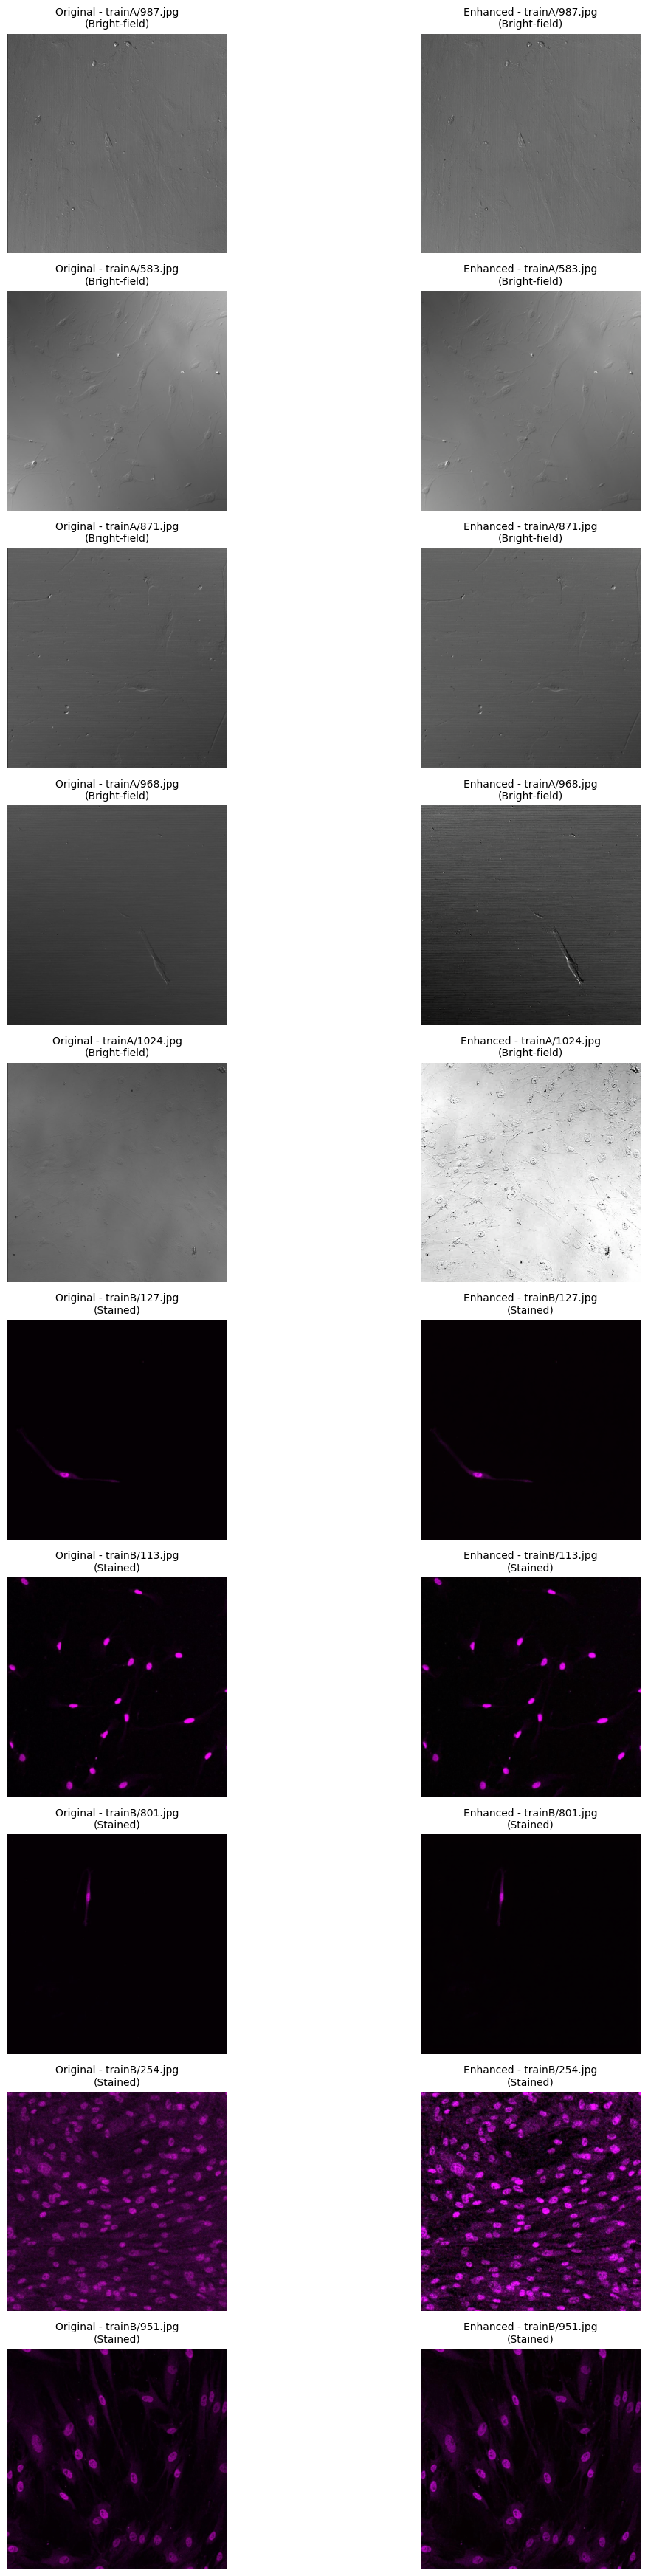

📊 Display completed, compared 10 image pairs
📈 Processing summary: 5 bright-field images, 5 stained images


In [4]:
# Compare and display enhancement results

if not results:
    print("⚠️ No processing results found, please run the image enhancement cell above first")
else:
    rows = len(results)
    plt.figure(figsize=(14, 3.5 * rows))
    
    for i, (orig, enhanced, label, image_type) in enumerate(results):
        # Original image
        plt.subplot(rows, 2, 2 * i + 1)
        plt.title(f"Original - {label}\n({image_type})", fontsize=10)
        plt.imshow(orig)
        plt.axis("off")
        
        # Enhanced image
        plt.subplot(rows, 2, 2 * i + 2)
        plt.title(f"Enhanced - {label}\n({image_type})", fontsize=10)
        plt.imshow(enhanced)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    print(f"📊 Display completed, compared {len(results)} image pairs")
    
    # Summary of processing
    brightfield_count = sum(1 for _, _, _, img_type in results if img_type == "Bright-field")
    stained_count = sum(1 for _, _, _, img_type in results if img_type == "Stained")
    print(f"📈 Processing summary: {brightfield_count} bright-field images, {stained_count} stained images")